In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
! pip install pyedflib

     |████████████████████████████████| 1.1MB 2.8MB/s 
  Created wheel for pyedflib: filename=pyEDFlib-0.1.15-cp36-cp36m-linux_x86_64.whl size=920116 sha256=542401a57208ff347d0e8cb820fba80ab5bc462fea3dddd244df5eb07ec1eaf9
  Stored in directory: /root/.cache/pip/wheels/57/e3/8e/ce6236e9ada08b8ff91ef922c7418dbd66f1182dfbb22f8579
Successfully built pyedflib


In [3]:
! pip install connectivipy

  Created wheel for connectivipy: filename=connectivipy-0.36-cp36-none-any.whl size=23689 sha256=e4453a077271773b3fc60bb1b63aa1941b5a905c78c75ec35b15e62f4ee06fcf
  Stored in directory: /root/.cache/pip/wheels/83/fd/d8/e1700c85ae7e9fecd3c572e9d4cb9f62b0568f7e962dd19402
Successfully built connectivipy


In [0]:
from __future__ import division, print_function, absolute_import
import numpy as np
import pyedflib
import matplotlib.pyplot as plt
import connectivipy as cp
import networkx as nx
import math
import csv

In [0]:
def load_data(name_of_file):
    f = pyedflib.EdfReader(name_of_file)
    n = f.signals_in_file
    signal_labels = f.getSignalLabels()
    sigbufs = np.zeros((n, f.getNSamples()[0]))
    for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)
    f.close()
    signal_labels = [signal.strip('.') for signal in signal_labels]

    return sigbufs,signal_labels

In [0]:
sigbufs1,signal_labels=load_data('/content/drive/My Drive/bioinfo_project_1-master/data/S071_S071R01.edf')

In [0]:
sigbufs2,signal_labels=load_data('/content/drive/My Drive/bioinfo_project_1-master/data/S071_S071R02.edf')

In [0]:
data1 = cp.Data(sigbufs1, 160, signal_labels)
data2 = cp.Data(sigbufs2, 160, signal_labels)

In [0]:
def AIC(p,M,N,Sp):
    aic=M*math.log(np.linalg.det(Sp))+(2*N**2*p)
    return aic

In [0]:
N,M = sigbufs1.shape


In [0]:
label_dict = {i: signal_labels[i] for i in range(N)}

In [0]:
def optimal_order(number_of_orders,data):
    minimum=99999999999
    optim_order=0
    aic_list=[]
    p_list=[]
    for i in range(1,number_of_orders):
        p_list.append(i)

        data.fit_mvar(i, 'yw')
        ar, vr = data.mvar_coefficients
        aic_list.append(AIC(i,M,N,vr))


        if AIC(i,M,N,vr)< minimum:
            minimum=AIC(i,M,N,vr)
            optim_order=i
    return aic_list,p_list,minimum,optim_order

In [0]:
def fit_model(method,data):
    aic, p, minimum, optim_order = optimal_order(20,data)
    print("Optimal order is", optim_order)
    print(minimum)
    plt.plot(p,aic)
    plt.show()
    data.fit_mvar(optim_order, 'yw')
    values = data.conn(method)
    significance = data.significance(Nrep=30, alpha=0.05)
    return significance

/usr/local/lib/python3.6/dist-packages/connectivipy/mvar/fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


Optimal order is 9
1923440.957366281


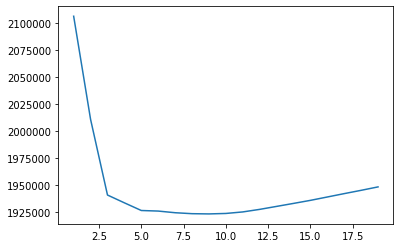

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . |


In [15]:
pdc_significance1=fit_model('pdc',data1)

/usr/local/lib/python3.6/dist-packages/connectivipy/mvar/fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


Optimal order is 7
1663455.1428923612


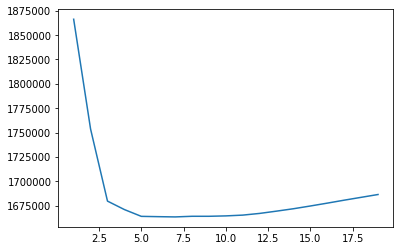

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . |


In [16]:
pdc_significance2=fit_model('pdc',data2)

In [0]:
def apply_threshold(significance, threshold, label_dictionary, positions=None):
    # apply threshold
    adj_matrix = np.where(significance>threshold, 1, 0)
    # remove self loops
    np.fill_diagonal(adj_matrix, 0)
    print("Number of edges: ", np.sum(adj_matrix))
    G = nx.DiGraph(adj_matrix)
    # calculate density
    print("Density:", nx.density(G))
    G_labels = nx.relabel_nodes(G, label_dictionary)
    return adj_matrix, G, G_labels

In [0]:
threshold = 0.121

In [0]:
np.fill_diagonal(pdc_significance1, 0)

In [20]:
adj_matrix1, G_pdc1,G_pdc1_labels = apply_threshold(pdc_significance1, threshold, label_dict)

Number of edges:  824
Density: 0.20436507936507936


In [0]:
threshold = 0.09

In [22]:
adj_matrix2, G_pdc2,G_pdc2_labels = apply_threshold(pdc_significance2, threshold, label_dict)

Number of edges:  799
Density: 0.19816468253968253


In [0]:
np.fill_diagonal(pdc_significance2, 0)

In [0]:
# in order to work, code needs G_pdc1_labels, G_pdc2_labels, 
# pdc_significance1, pdc_significance2 objects

### 4. Community detection
4.1. (mandatory) Determine number and composition (i.e. list of nodes) of the communities obtained applying one of the algorithms introduced during the course. = FIND COMMUNITIES WITH ONE ALGO

4.2. (class ‘B’) Make a graphical representation of the community structure in both rest conditions.

4.3. (class ‘C’) Compare the community structure obtained by means of two different methods (modularity-based vs information theory-based approaches).

In [0]:
# 4.1 using Louvain Algorithm
# algo from https://python-louvain.readthedocs.io/en/latest/

In [0]:
G_pdc1_labels_undir = G_pdc1_labels.to_undirected()
G_pdc2_labels_undir = G_pdc2_labels.to_undirected()

In [40]:
!pip install python-louvain

In [0]:
# find communities using Louvain Algorithm
import community
import networkx as nx
import matplotlib.pyplot as plt

# compute the best partition using Louvain Algorithm
partition_G_pdc1 = community.best_partition(G_pdc1_labels_undir)
partition_G_pdc2 = community.best_partition(G_pdc2_labels_undir)

In [42]:
# Determine number of the communities:
print('number of pdc1 communities: ', len(set(partition_G_pdc1.values())))
print('number of pdc2 communities: ', len(set(partition_G_pdc2.values())))

number of pdc1 communities:  4
number of pdc2 communities:  5


In [0]:
# Determine composition of the communities:
def communities_composition(partition):
  count = 0.
  communities = []
  for com in set(partition.values()) :
      count = count + 1.
      list_nodes = [nodes for nodes in partition.keys()
                                  if partition[nodes] == com]
      communities.append((com, list_nodes))
  return communities

In [0]:
communities1 = communities_composition(partition_G_pdc1)
communities2 = communities_composition(partition_G_pdc2)

In [45]:
# Composition of the communities:
print('pdc1 communities: ')
for elem in communities1:
  print(elem)
print('pdc2 communities: ')
for elem in communities2:
  print(elem)

pdc1 communities: 
(0, ['Fc5', 'Fc4', 'Fc6', 'Cp3', 'Fp2', 'Afz', 'F5', 'Ft8', 'T9', 'Tp7', 'P5', 'P2', 'P4', 'Iz'])
(1, ['Fc3', 'Fc1', 'Fc2', 'C5', 'Cz', 'Cp1', 'Cp4', 'Cp6', 'Fp1', 'Fpz', 'F7', 'F6', 'F8', 'Ft7', 'T7', 'Tp8', 'P7', 'Po7', 'Po3', 'Poz', 'Po8'])
(2, ['Fcz', 'C1', 'C4', 'C6', 'Cp5', 'Af7', 'Af8', 'F3', 'Fz', 'F2', 'F4', 'T10', 'P1', 'P6', 'O1', 'O2'])
(3, ['C3', 'C2', 'Cpz', 'Cp2', 'Af3', 'Af4', 'F1', 'T8', 'P3', 'Pz', 'P8', 'Po4', 'Oz'])
pdc2 communities: 
(0, ['Fc5', 'Fcz', 'Fc2', 'Fc6', 'Cz', 'C2', 'Afz', 'F7', 'F8', 'T9', 'T10', 'P5', 'Po4', 'Iz'])
(1, ['Fc3', 'C1', 'C6', 'Cpz', 'Cp2', 'Cp4', 'Fpz', 'Af8', 'F5', 'Tp8', 'P7', 'P4', 'P8', 'Poz', 'Oz'])
(2, ['Fc1', 'Fc4', 'Fp1', 'Af4', 'Fz', 'F2', 'Tp7', 'P1', 'Pz', 'Po3', 'Po8', 'O1'])
(3, ['C5', 'Cp5', 'Cp1', 'Cp6', 'Fp2', 'Af7', 'F6', 'T8', 'P2', 'Po7', 'O2'])
(4, ['C3', 'C4', 'Cp3', 'Af3', 'F3', 'F1', 'F4', 'Ft7', 'Ft8', 'T7', 'P3', 'P6'])


## 4.2

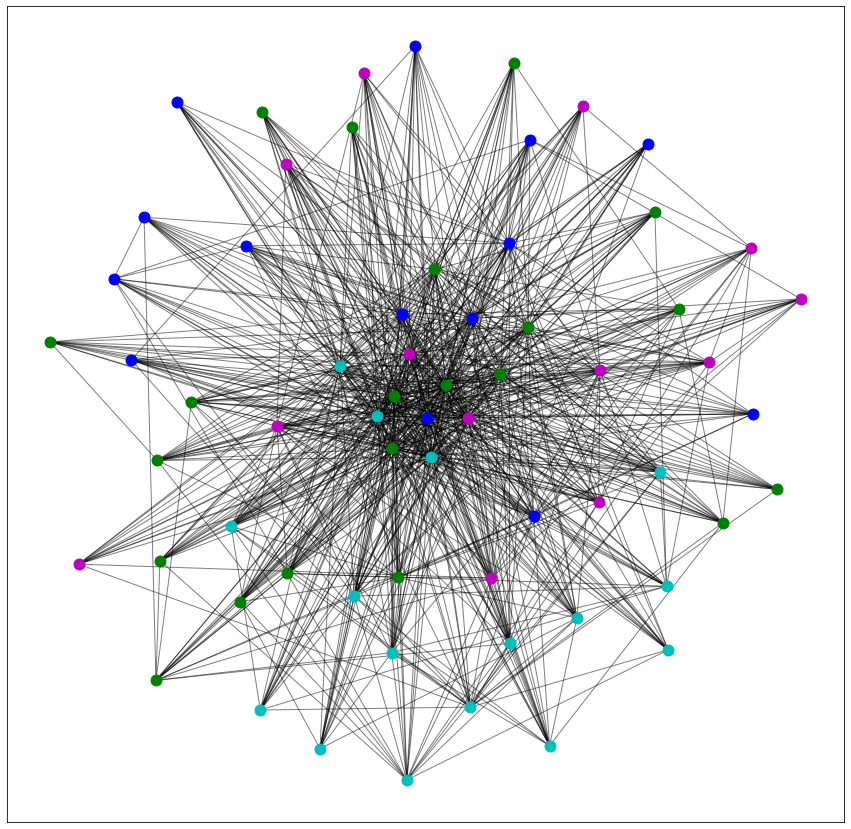

<Figure size 432x288 with 0 Axes>

In [46]:
#drawing pdc1 communities:
from matplotlib.pyplot import figure
figure(figsize=(15,15))
size = float(len(set(partition_G_pdc1.values())))
pos = nx.spring_layout(G_pdc1_labels_undir) 
count = 0
node_color_val = ['b', 'g', 'c', 'm', 'y', 'r']
for com in set(partition_G_pdc1.values()) :
    list_nodes = [nodes for nodes in partition_G_pdc1.keys()
                                if partition_G_pdc1[nodes] == com]
    nx.draw_networkx_nodes(G_pdc1_labels_undir, pos, list_nodes, node_size = 120,
                                node_color = node_color_val[count])
    count = count + 1
nx.draw_networkx_edges(G_pdc1_labels_undir, pos, alpha=0.5)
plt.show()
plt.savefig("louvain_pdc1.png", format="PNG")

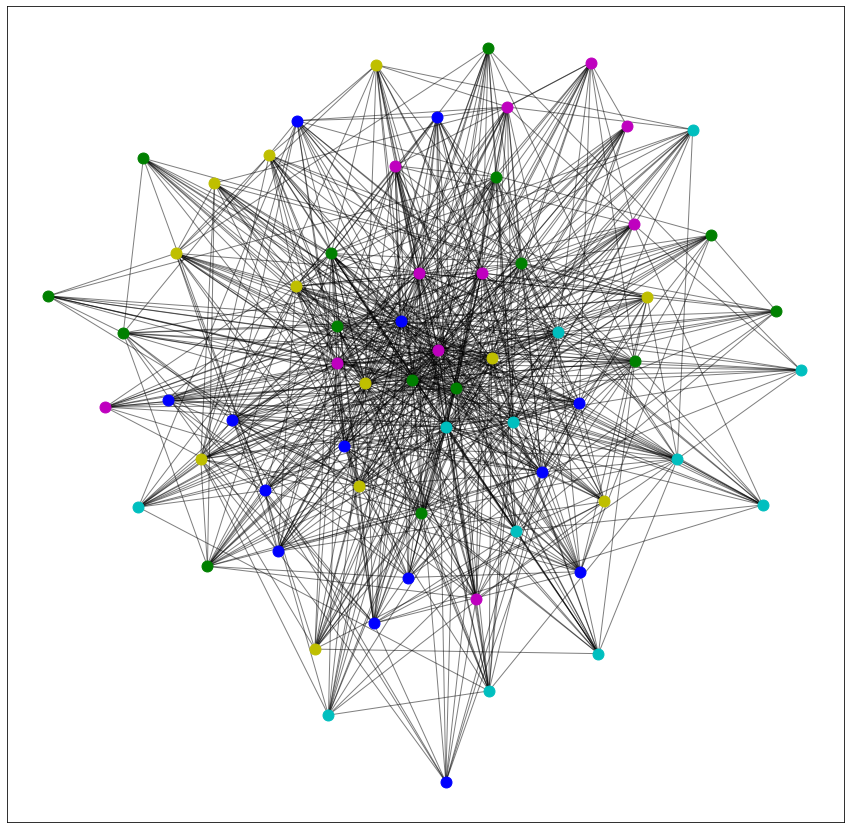

<Figure size 432x288 with 0 Axes>

In [47]:
#drawing pdc2 communities:
figure(figsize=(15,15))
size = float(len(set(partition_G_pdc2.values())))
pos = nx.spring_layout(G_pdc2_labels_undir) 
count = 0
node_color_val = ['b', 'g', 'c', 'm', 'y', 'r']
for com in set(partition_G_pdc2.values()) :
    list_nodes = [nodes for nodes in partition_G_pdc2.keys()
                                if partition_G_pdc2[nodes] == com]
    nx.draw_networkx_nodes(G_pdc2_labels_undir, pos, list_nodes, node_size = 120,
                                node_color = node_color_val[count])
    count = count + 1
nx.draw_networkx_edges(G_pdc2_labels_undir, pos, alpha=0.5)
plt.show()
plt.savefig("louvain_pdc2.png", format="PNG")

## 4.3

In [24]:
! pip install python-igraph

     |████████████████████████████████| 378kB 2.7MB/s 
  Created wheel for python-igraph: filename=python_igraph-0.7.1.post6-cp36-cp36m-linux_x86_64.whl size=2217184 sha256=b6c927a25ac8fa6ffb21b8d0523a861708393885d6e832629446aaf1df5f76fb
  Stored in directory: /root/.cache/pip/wheels/41/d6/02/34eebae97e25f5b87d60f4c0687e00523e3f244fa41bc3f4a7
Successfully built python-igraph


In [0]:
import igraph

In [0]:
G1_w = igraph.Graph.Weighted_Adjacency(pdc_significance1.tolist())
G2_w = igraph.Graph.Weighted_Adjacency(pdc_significance2.tolist())

In [27]:
community_pdc1 = G1_w.community_infomap(edge_weights=G1_w.es["weight"],trials=100)
codelength_pdc1 = community_pdc1.codelength
print("code-length:", codelength_pdc1)
print("no. of communities: ", max(community_pdc1.membership) + 1)
print(community_pdc1)
community_pdc2 = G2_w.community_infomap(edge_weights=G2_w.es["weight"],trials=100)
codelength_pdc2 = community_pdc2.codelength
print("code-length:", codelength_pdc2)
print("no. of communities: ", max(community_pdc2.membership) + 1)
print(community_pdc2)

code-length: 5.952579529853982
no. of communities:  1
Clustering with 64 elements and 1 clusters
[0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
    21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
    39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
    57, 58, 59, 60, 61, 62, 63
code-length: 5.982702554446541
no. of communities:  1
Clustering with 64 elements and 1 clusters
[0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
    21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
    39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
    57, 58, 59, 60, 61, 62, 63


In [0]:
G1_w_nx = nx.DiGraph(G1_w.get_edgelist()) 
G2_w_nx = nx.DiGraph(G2_w.get_edgelist())

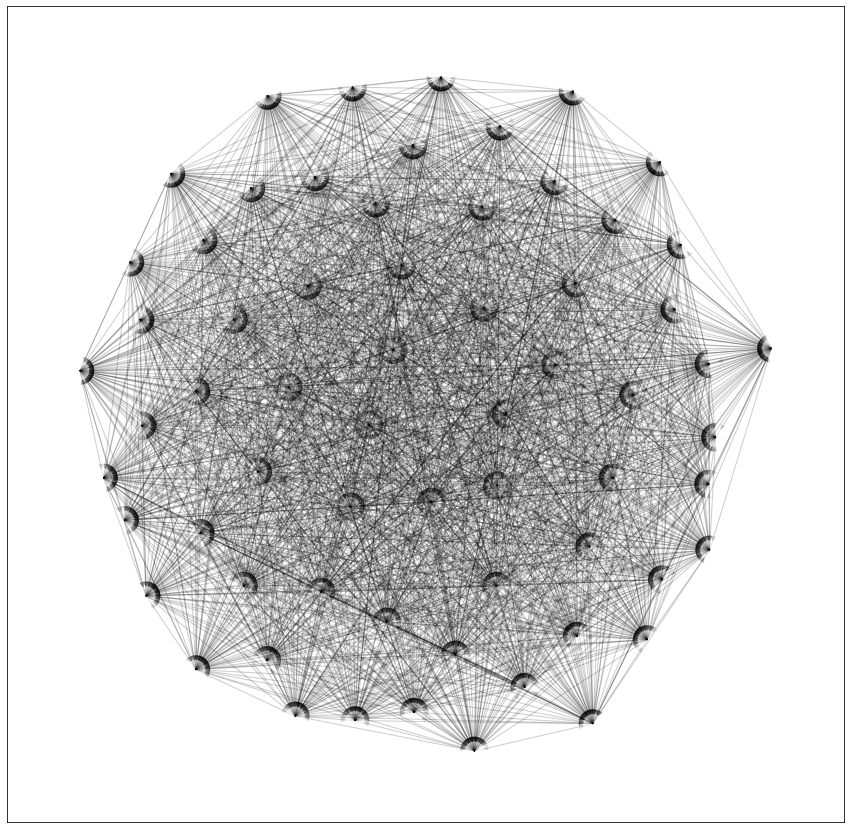

<Figure size 432x288 with 0 Axes>

In [48]:
from matplotlib.pyplot import figure
figure(figsize=(15,15))
pos = nx.spring_layout(G1_w_nx)
nx.draw_networkx_edges(G1_w_nx,pos,alpha=0.1)
plt.show()
plt.savefig("infomap_pdc1.png", format="PNG")

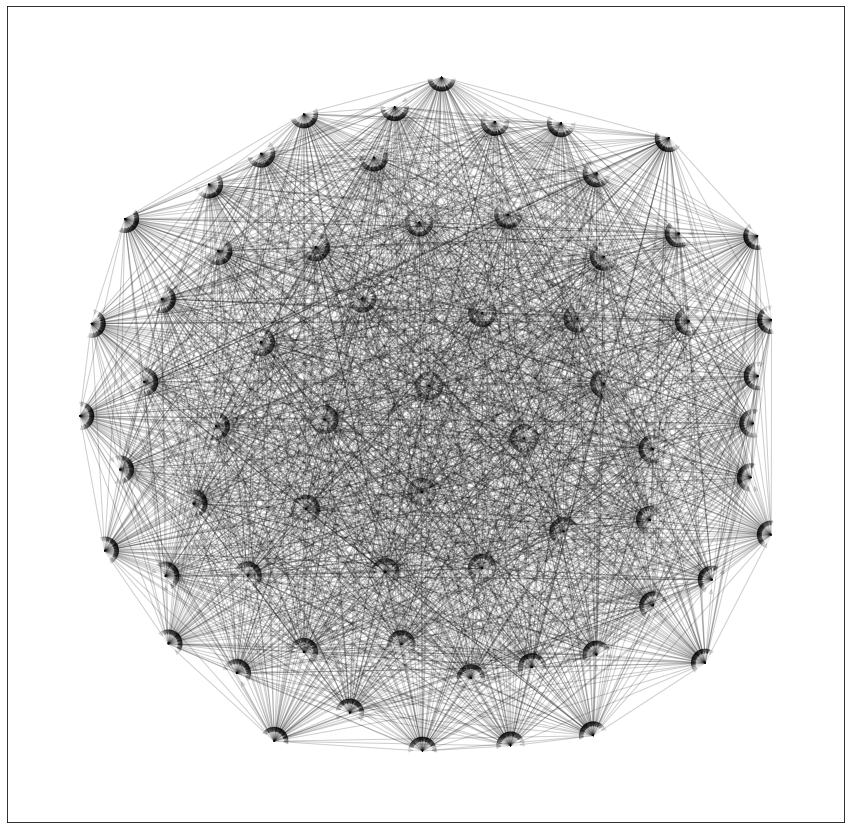

<Figure size 432x288 with 0 Axes>

In [49]:
from matplotlib.pyplot import figure
figure(figsize=(15,15))
pos = nx.spring_layout(G2_w_nx)
nx.draw_networkx_edges(G2_w_nx,pos,alpha=0.1)
plt.show()
plt.savefig("infomap_pdc2.png", format="PNG")